In [1]:
#pip install tensorflow

## prepare

In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np

# Importing standard Qiskit libraries
import qiskit
from typing import Dict, List
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
import pickle
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize

In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
data_shape = X_train[0].shape

## normalize

In [5]:
28*28

784

In [8]:
2**int(np.ceil(np.log2(X_train[0].size)))

1024

In [10]:
def normalize(x):
    """
    """
    x = x.flatten()
    normalized_vector = x / np.linalg.norm(x)
    total_size = 2**int(np.ceil(np.log2(X_train[0].size)))
    normalized_vector = [*normalized_vector, *np.zeros(total_size-len(normalized_vector))]
    return normalized_vector
def de_normalize(normalized_vector, x):
    return normalized_vector * np.linalg.norm(x.flatten())

In [11]:
normalized_vector = np.array(normalize(X_train[0]))
de_normalized_vector = de_normalize(normalized_vector,np.array(X_train[0]))

In [12]:
np.allclose(
        X_train[0], np.reshape(np.array(de_normalized_vector[:784]),data_shape), rtol=1e-2
    )

True

In [15]:
X_train_list = []
for i in range(100):
    X_train_list.append(normalize(X_train[i]))

np.shape(X_train_list)

(100, 1024)

In [16]:
X_test_list = []
for i in range(100):
    X_test_list.append(normalize(X_test[i]))
np.shape(X_test_list)

(100, 1024)

## encoding

before normalize:


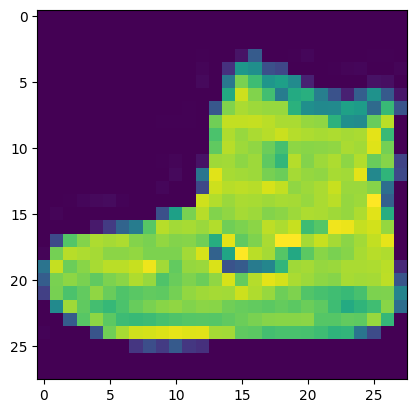

In [17]:
print('before normalize:')
display(plt.imshow(X_train[0]))

after normalize:


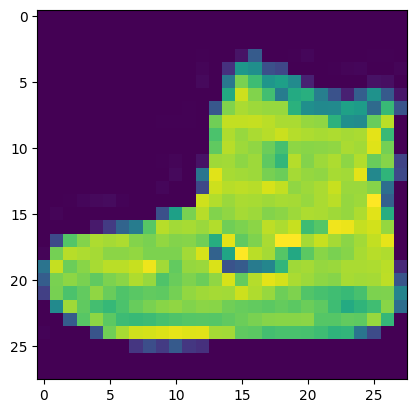

In [18]:
normalized_vector = normalize(X_train[0])
#print(normalized_vector)
print('after normalize:')
plt.imshow(np.reshape(np.array(normalized_vector[:784]),data_shape))

In [19]:
import numpy as np
import cv2

def amplitude_encode(img, depth=11):
    # Quantize image intensity values into depth levels
    quantized = np.clip(np.round(img / (256 / depth)), 0, depth - 1).astype(np.uint8)
    # Map quantized intensity levels to amplitude values
    amplitudes = quantized * (256 / depth)
    return amplitudes

# Load an image
img = X_train[0]#cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
# Do amplitude encoding with a depth of 11
encoded = amplitude_encode(img, depth=11)

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer
import numpy as np

# Function to angle encode a part of the image
def angle_encode_part(part, qc, qr, cr, n_qubits):
    # Convert the part of the image to an angle value in radians
    angle = 2 * np.pi * part / 256
    # Apply the angle encoding using n_qubits qubits
    for i in range(n_qubits):
        qc.ry(angle, qr[i])
    # Measure the qubits
    for i in range(n_qubits):
        qc.measure(qr[i], cr[i])

# Define the number of qubits to use for each part
n_qubits = 4

# Define the size of the parts
part_size = 28 // np.sqrt(n_qubits)

# Load the image
img = X_train[0]#.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Cut the image into parts
parts = [img[i:i+part_size, j:j+part_size] for i in range(0, img.shape[0], part_size)
         for j in range(0, img.shape[1], part_size)]

# Initialize the quantum circuit and registers
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
qc = QuantumCircuit(qr, cr)

# Loop over each part and apply angle encoding
for part in parts:
    angle_encode_part(part, qc, qr, cr, n_qubits)

# Execute the circuit on a simulator
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1)
result = job.result()

# Collect the results
encoded_parts = [int(''.join([str(x) for x in result.get_counts(i).keys()]), 2)
                 for i in range(len(parts))]

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [17]:
#scaler.inverse_transform(scaler.transform(X_train[0]))

## circuit

In [18]:
state = normalized_vector
n = 10
qc = RawFeatureVector(2**n)
#qc = qc.bind_parameters(state)
#qc.measure_all()

#qc_ = qc.decompose(reps=20)
#print(qc_.depth())
#print(f"Circuit operations: {qc_.count_ops()}")
## qc.decompose(reps = 9).draw()
qc.num_parameters

1024

## test encoding & decoding (1st task)

In [19]:
import qiskit
from qiskit import BasicAer

def simulate(circ: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend,optimization_level=0,shots=1024)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

In [20]:
#histogram = simulate(qc.bind_parameters(normalized_vector))
#print(histogram)
#new_histogram = {}
#
#for key in range(len(qc.parameters)):
#    if key in histogram:
#        new_histogram[key] = histogram[key]
#    else:
#        new_histogram[key] = 0
#print(new_histogram)

In [21]:
#import matplotlib.pyplot as plt
#after_ = np.array(list(new_histogram.values())[:784])
#plt.imshow(np.reshape(after_,data_shape))

In [22]:
#de_normalized_vector = de_normalize(after_,X_train[0])
#plt.imshow(np.reshape(after_,data_shape))

In [27]:
from qiskit.circuit.library import StatePreparation
def encode_qiskit(x,num_qubit=10):
    normalized_vector = normalize(x)
    qc = RawFeatureVector(2**num_qubit) #
    qc = qc.bind_parameters(normalized_vector)
    return qc

def decode(histogram,data):
    new_histogram = {}
    for key in range(len(qc.parameters)):
        if key in histogram:
            new_histogram[key] = histogram[key]
        else:
            new_histogram[key] = 0
    #print(new_histogram)
    after_ = np.array(list(new_histogram.values()))
    return np.reshape(de_normalize(after_,data)[:784],data_shape)

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [28]:
#grade part1
#from part1 import encode_qiskit,decode
from collections import Counter
from sklearn.metrics import mean_squared_error

dataset = X_train[:1]

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data)
    
    #simulate circuit
    histogram=simulate(circuit)
    
    gatecount+=count_gates(circuit)[2]
    
    #reconstruct 
    image_re=decode(histogram,data)
    print(image_re)
    
    #calculate mse
    mse+=image_mse(np.asarray(data),np.asarray(image_re))
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))
# score should be between 0 and 1

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00

In [25]:
def multiply_by_51(lst):
    new_list = []
    for element in lst:
        new_list.append(element * 51)
    return new_list

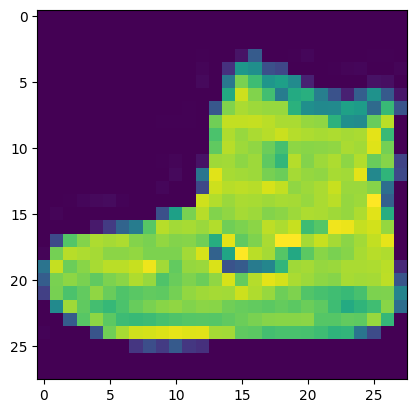

In [26]:
plt.imshow(data)

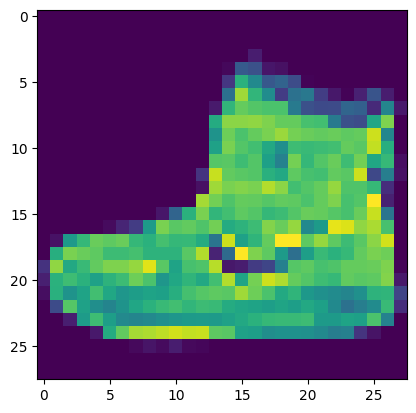

In [31]:
list(list(de_normalize(image_re,data)[:784]))
plt.imshow(np.reshape(multiply_by_51(list(de_normalize(image_re,data)[:784])),data_shape))

## train classifier circuit (2nd task)
is there a way to get the best classifier?  

Important Final Note: The goal of this problem is to explore quantum computing approaches to machine learning problems. To this end, the final score will take into account the degree of quantumness in the program. Preference will be given to creative solutions with a minimal amount of classical processing in the final solution.

reference:   
[1] calculate result from probability, https://github.com/ericardomuten/quantum_image_classifier  
[2] MPS tensor circuit(ideal classifier circuit), https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.043007 , good example from qamp-mentorship https://github.com/qiskit-advocate/qamp-fall-22/issues/28   
[3] Good idea about amplitude circuit, https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.031041

In [14]:
from IPython.display import clear_output
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA
vqc = VQC(
    feature_map=qc,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=100),
    quantum_instance=Aer.get_backend('statevector_simulator'),
    callback=callback_graph
)

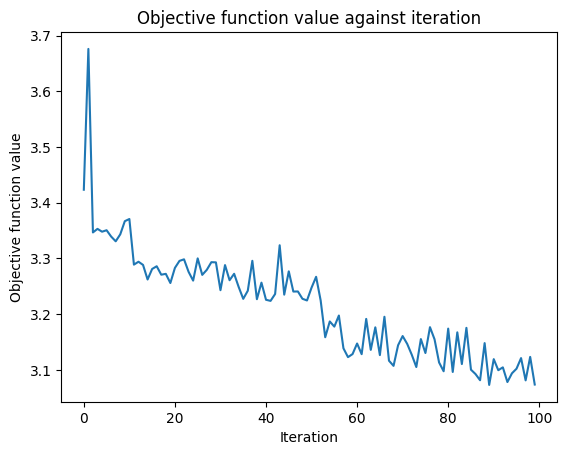

Time elapsed:  1189.4153316020966


In [16]:
import time
start = time.time()

objective_func_vals = []
vqc.fit(np.array(X_train_list),np.array(Y_train[:100]))
plt.rcParams["figure.figsize"] = (6, 4)

own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

In [17]:
vqc.score(X_test_list[:50],Y_test[:50])

0.4

In [20]:
classifier = ansatz.bind_parameters(vqc._fit_result.x).qasm()
print(classifier)

OPENQASM 2.0;
include "qelib1.inc";
gate gate_RealAmplitudes(param0,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,param11,param12,param13,param14,param15,param16,param17,param18,param19,param20,param21,param22,param23,param24,param25,param26,param27,param28,param29) q0,q1,q2,q3,q4,q5,q6,q7,q8,q9 { ry(0.266317714019139) q0; ry(1.32035044188513) q1; ry(0.375724625916453) q2; ry(-0.145527578194223) q3; ry(1.24796981173025) q4; ry(-0.3722525242738) q5; ry(0.98731246639232) q6; ry(1.98782341512519) q7; ry(1.66430495324693) q8; ry(0.760045740348774) q9; cx q8,q9; cx q7,q8; cx q6,q7; cx q5,q6; cx q4,q5; cx q3,q4; cx q2,q3; cx q1,q2; cx q0,q1; ry(1.76943425343952) q0; ry(1.54002486179664) q1; ry(1.5166941190635) q2; ry(2.08820456685236) q3; ry(0.502872321522427) q4; ry(0.5226897740692) q5; ry(1.34895736320983) q6; ry(0.17808386546728) q7; ry(1.48787325816064) q8; ry(1.19251464386051) q9; cx q8,q9; cx q7,q8; cx q6,q7; cx q5,q6; cx q4,q5; cx q3,q4; cx q2,q3; cx q1,q2; cx

In [ ]:
# todo: histogram_to_category
#def histogram_to_category():


In [ ]:
##grade part 2
#
##load classifier circuit
##classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
#    
#score=0
#
#for data in dataset:
#    #encode image into circuit
#    circuit=encode_qiskit(data['image'])
#    
#    nq1 = circuit.width()
#    nq2 = classifier.width()
#    nq = max(nq1, nq2)
#    qc = qiskit.QuantumCircuit(nq)
#    qc.append(circuit.to_instruction(), list(range(nq1)))
#    qc.append(classifier.to_instruction(), list(range(nq2)))
#
#    gatecount+=count_gates(qc)[2]
#    
#    #simulate circuit
#    histogram=simulate(qc)
#    
#    #convert histogram to category
#    cat=histogram_to_category(histogram)
#    
#    
#    if cat==data['category']:
#        score+=1
##score
#score=score/n
#gatecount=gatecount/n
#
#print(score*(0.999**gatecount))